<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


# Kinematische Elemente Methode, Schmierschicht

Die hier verwendete Methode wird näher erläutert in https://nagelt.github.io/Teaching_Scripts/KEM.html.

Das folgende Beispiel ist an Ziegler, M. (2012). Geotechnische Nachweise nach EC 7 und DIN 1054. Weinheim, Germany: Wiley-VCH Verlag GmbH & Co. KGaA, angelehnt.

![KEM.png](https://raw.githubusercontent.com/nagelt/Teaching_Scripts/master/Images/Ziegler_slope.png)
[Bild aus: Ziegler, M. (2012).]

In [633]:
import numpy as np #numerical methods
import matplotlib.pyplot as plt #plotting
import pandas as pd
import scipy as scp
from scipy import optimize
import concurrent.futures as cf

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/KEM_plots.ipynb

Wir definieren zunächst die Geometrie des Problems, legen also die kinematischen Elemente des Bruchmechanismus fest.

In [634]:
H_top_slope = 6.5
H_top_layer = 2.1
alpha = np.deg2rad(35)
beta = np.deg2rad(12)
theta = np.deg2rad(54)

Aus den gegebenen Größen lassen sich die verbliebenen Größen über trigonometrische Standardbeziehungen bestimmen.

In [635]:
geometry = pd.DataFrame(np.array([[1],
                                  [0.0],
                                  [H_top_layer]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
#geometry

In [636]:
dH = H_top_slope - H_top_layer
geometry = pd.concat([geometry,pd.DataFrame({'Pkt': 2, 'x / m': dH/np.tan(alpha) + dH*np.tan(beta), 'y / m': H_top_layer},index=[0])], ignore_index=True)
geometry = pd.concat([geometry,pd.DataFrame({'Pkt': 3, 'x / m': dH/np.tan(alpha), 'y / m': H_top_slope},index=[0])], ignore_index=True)
geometry = pd.concat([geometry,pd.DataFrame({'Pkt': 4, 'x / m': dH/np.tan(alpha) + dH*np.tan(beta) + dH/np.tan(theta), 'y / m': H_top_slope},index=[0])], ignore_index=True)

In [637]:
#Achtung: Nummerierung im Umlaufsinn!
block1 = define_element(geometry,[3,2,4])
block2 = define_element(geometry,[1,2,3])

In der Darstellung ergibt sich folgende Böschungsgeometrie.

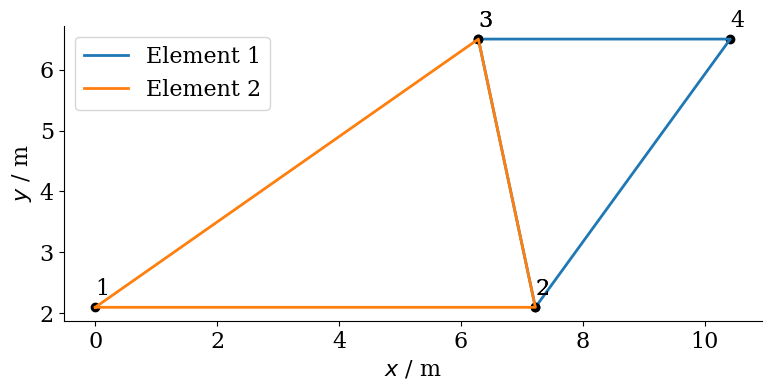

In [638]:
plot_blocks([block1,block2])

## Kinematik, Geschwindigkeitsplan

Zunächst betrachten wir die (vereinfachte) Kinematik des Systems und ermitteln den Geschwindigkeitsplan. Alle Geschwindigkeiten sind determiniert, sobald die Geschwindigkeit eines Körpers vorgegeben wird. Das System hat also einen Freiheitsgrad. Die Bewegungsrichtung der einzelnen Gleitkörper sei durch die Gleitfugen vorgegeben. Mit dieser Information lässt sich also der Geschwindigkeitsplan zeichnen, aus dem sich dann auch die Wirkungsrichtung von Kohäsions- und Reibungskräften in den Gleitfugen ablesen lässt.

Geben wir also ohne Einschränkung der Allgemeinheit die Geschwindigkeit von Element 1 entlag seiner äußeren Gleitfuge $\vec{v}_{1}$ so vor, dass $|\vec{v}_{1}| = 1\,$m/s gilt. Die gleitfugenparallelen Geschwindigkeiten $\vec{v}_{2}$ und $\vec{v}_{21}$ kennen wir zunächst nur der Richtung nach. Die beiden Indizes für die Geschwindigkeit entlang der inneren Gleitfuge definieren die Bewegungsrichtung als "2 relativ zu 1".

In [639]:
v_1 = line_of_Q(geometry, np.eye(2),4,2)
e_v2 = line_of_Q(geometry, np.eye(2),2,1)
e_v21 = line_of_Q(geometry, np.eye(2),2,3)

Die Länge der Vektoren ergibt sich nun daraus, dass die Relativbewegung zweier Körper wiederum durch die gemeinsame Gleitfuge vorgegeben ist. Die Schnittpunkte der Wirkungslinien bestimmen die Beträge der Relativgeschwindigkeiten (Maßstab beachten).

Die Geschwindigkeit des Körpers eins ergibt sich aus der Geschwindigkeit des Körpers 1 zuzüglich der Relativgeschwindigkeit von 2 zu 1:

$$
    \vec{v}_2 = \vec{v}_1 + \vec{v}_{21}
$$

Mathematisch suchen wir also die Lösung für folgende Gleichungen (2 Gleichungen für 2 Unbekannte in einer 2D Vektorgleichung zusammengefasst):

\begin{align}
    \vec{0} &= -f_{2} \vec{e}_{v_{2}} + f_{21} \vec{e}_{v_{21}} + \vec{v}_1
\end{align}

Wir suchen also die zwei skalaren Faktoren $f_{ij}$, die die Richtungsvectoren $\vec{e}_{v_{ij}}$ so skalieren, dass sich die Geschwindigkeiten gemäß des vorgegebenen Bruchmechanismus addieren.

In [640]:
b_v = v_1
A_v = np.array([e_v2,-e_v21]).T

In [641]:
f_v = np.linalg.solve(A_v,b_v)

In [642]:
v_2 = f_v[0]*e_v2
v_21 = f_v[1]*e_v21

Nun können wir den gesamten Geschwindigkeitsplan zeichnen, und so die Lösung graphisch bestätigen.

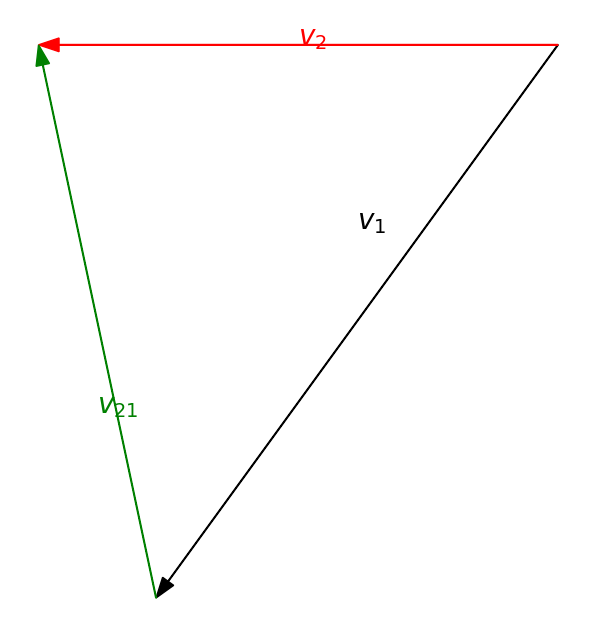

In [643]:
scale = 0.2
fig, ax = plt.subplots(figsize=(8,8))
vec_from_by(ax,delta=v_1,label=r'$v_{1}$',scale=scale)
#
vec_from_by(ax,delta=v_2,scale=scale,label=r'${v_{2}}$',col='red')
vec_from_by(ax,fro=v_1,delta=v_21,scale=scale,label=r'${v_{21}}$',col='green')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Statik, Kräfteplan

Jetzt können wir weitere wesentliche Größen ausrechnen. Genauer gesagt, können wir die Gewichtskräfte der einzelnen kinematischen Elemente aus ihren Flächeninhalten ableiten. Dazu legen wir die wesentlichen Materialeigenschaften sowie die Belastung fest. Es werden die Bemessungswerte eingesetzt. Man beachte, dass in der nachfolgenden Tabelle die Wichte in kN/m³, die Kohäsion in kN/m² und der Reibungswinkel im Bogenmaß angegeben sind (entsprechend 27° und 10.5°).

In [644]:
material = pd.DataFrame(np.array([['Wichte', 'phi', 'c'],
                                  [19, np.deg2rad(27), 5.6],
                                  [18, np.deg2rad(10.5), 0.]]).T,
                   columns=['Parameter', 'Schluff', 'Schmierschicht'])
material

,Parameter,Schluff,Schmierschicht
0,Wichte,19,18
1,phi,0.47123889803846897,0.1832595714594046
2,c,5.6,0.0


Eine Last von 35 kN/m² (repräsentativer Wert) wirkt auf einer Länge von 1 bis 6 m hinter der Böschungsschulter. Der zugehörige Teilsicherheitsbeiwert beträgt 1.3.

In [645]:
top_load = 35.0 * 1.3 #kN/m²
x_shoulder = geometry.loc[geometry['Pkt']==3].iloc[0]['x / m']
x_load = np.array([x_shoulder + 1,x_shoulder+6]) #Load starts 1m behind shoulder and extends for 5m

In [646]:
data = {'A / m²': np.array([block_area(block1),block_area(block2)])} #in m

In [647]:
data['G / kN/m'] = data['A / m²']*float(material.loc[material['Parameter']=='Wichte'].iloc[0]['Schluff'])

Aus Geometrie und Wichten ergeben sich folgende Eigenschaften bzw. Einwirkungen.

In [648]:
blockdata = pd.DataFrame(data)
blockdata

,A / m²,G / kN/m
0,9.090479,172.719105
1,15.882020,301.758384


## Kräftegleichgewicht

Bestimmen wir zunächst die statisch äquivalente Auflast. Da das Momentengleichgewicht unbeachtet bleibt, wird ihr Angriffspunkt nicht benötigt.

In [649]:
P = np.array([0,-get_top_load(geometry,top_load,x_load)])
P

array([   0.        , -142.50763775])

Sammeln wir zunächst die aus der Geometrie und den Materialeigenschaften bekannten Kräfte

In [650]:
G_1 = gravity_vector(blockdata,1)
G_1

array([   0.        , -172.71910457])

In [651]:
G_2 = gravity_vector(blockdata,2)
G_2

array([   0.        , -301.75838422])

Die Kohäsionskräfte werden aus der Länge der Gleitfuge bestimmt. Ihre Richtung folgt aus dem Geschwindigkeitsplan als bewegungshemmend. Ebenso können die Wirkungslinien der Gleitflächenresultierenden $\vec{Q}$ durch mathematisch positive oder negative Rotation der Geschwindigkeitsvektoren um $90° + \varphi$ bestimmt werden -- vorgegeben durch Kreuzprodukt aus Geschwindigkeitsvektor und Einheitsnormalenvektor der Gleitfuge bzw. durch Anschauung aus dem Geschwindigkeitsplan.

In [652]:
C_1 = cohesion_v(float(material.loc[material['Parameter']=='c'].iloc[0]['Schluff']),v_1,geometry,2,4)
print("Die Kohäsionskraft C1 beträgt %.2f kN/m" %np.linalg.norm(C_1))
C_1

Die Kohäsionskraft C1 beträgt 30.46 kN/m


array([17.90200789, 24.64      ])

In [653]:
C_2 = cohesion_v(float(material.loc[material['Parameter']=='c'].iloc[0]['Schmierschicht']),v_2,geometry,1,2)
print("Die Kohäsionskraft C2 beträgt %.2f kN/m" %np.linalg.norm(C_2))
C_2

Die Kohäsionskraft C2 beträgt 0.00 kN/m


array([ 0., -0.])

In [654]:
C_12 = cohesion_v(float(material.loc[material['Parameter']=='c'].iloc[0]['Schluff']),-v_21,geometry,2,3)
print("Die Kohäsionskraft C12 beträgt %.2f kN/m" %np.linalg.norm(C_12))
C_21 = cohesion_v(float(material.loc[material['Parameter']=='c'].iloc[0]['Schluff']),v_21,geometry,2,3)
print("Die Kohäsionskraft C21 beträgt %.2f kN/m" %np.linalg.norm(C_21))
print(C_12,C_21)

Die Kohäsionskraft C12 beträgt 25.19 kN/m
Die Kohäsionskraft C21 beträgt 25.19 kN/m
[-5.23739368 24.64      ] [  5.23739368 -24.64      ]


In [655]:
e_Q1 = line_of_Q_v(float(material.loc[material['Parameter']=='phi'].iloc[0]['Schluff']),v_1)
e_Q2 = line_of_Q_v(float(material.loc[material['Parameter']=='phi'].iloc[0]['Schmierschicht']),v_2)
e_Q12 = line_of_Q_v(float(material.loc[material['Parameter']=='phi'].iloc[0]['Schluff']),-v_21,False)
e_Q21 = line_of_Q_v(float(material.loc[material['Parameter']=='phi'].iloc[0]['Schluff']),v_21,False)
print(e_Q12,e_Q21)

[0.77714596 0.62932039] [-0.77714596 -0.62932039]


Nun schließen wir die Kraftecke (Vektorsumme Null). Die Kräfte an den inneren Gleitfugen werden einerseits berechnet, um einerseits etwa Zugkräfte durch unzulässige Geometrien ausschließen zu können, andererseits die Dissipationsleistung berechnen zu können. Damit allerdings das Kräftegleichgewicht gilt, wird eine zusätzliche unbekannte Kraft $\Delta \vec{F}$ eingeführt, die haltend oder treibend eingreift. Sie wirke hier auf Körper 2, ihre Wirkungslinie sei parallel zur Schmierschicht in treibender Richtung.

Mathematisch gilt es, die Skalierfaktoren $f_i$ zu bestimmen, so dass gilt:

$$
    \vec{0} = \vec{P} + \vec{G}_1 + \vec{C}_{1} + \vec{C}_{12} + f_{12} \vec{e}_{Q_{12}} + f_{1} \vec{e}_{Q_{1}}
$$

sowie

\begin{align}
    \vec{0} &= \Delta \vec{F} + \vec{G}_2 + \vec{C}_{2} + \vec{C}_{21} + f_{21} \vec{e}_{Q_{21}} + f_{2} \vec{e}_{Q_{2}}
    \\
    &= f_F \vec{e}_{\Delta {F}} + \vec{G}_2 + \vec{C}_{2} + \vec{C}_{21} + f_{21} \vec{e}_{Q_{21}} + f_{2} \vec{e}_{Q_{2}}
\end{align}

Als fünfte Gleichung sei $f_{21}=f_{12}$ eingeführt. Man beachte, dass unter direkter Verwendung dieser Bedingung in den obigen Gleichungen auch ein $(4\times4)$ System aufgestellt werden könnte. Außerdem muss gelten $f_{ij} \geq 0$. Liegt $f_F < 0$ vor, so wirkt die zusätzliche Kraft haltend und der Mechanismus ist nicht standischer.

In [656]:
e_F = v_2/np.linalg.norm(v_2)

In [657]:
b_F = np.append(-np.append(G_1+C_1+C_12+P,G_2+C_2+C_21),0)
A_F = np.zeros((5,5))
A_F[0:2,0] = e_Q12
A_F[0:2,1] = e_Q1
A_F[2:4,2] = e_Q21
A_F[2:4,3] = e_Q2
A_F[2:4,4] = e_F
A_F[4,0] = 1
A_F[4,2] = -1

In [658]:
f_F = np.linalg.solve(A_F,b_F)
f_F

array([111.8982866 , 219.44493507, 111.8982866 , 403.57617811,
        -8.17799095])

In [659]:
if (f_F[0:4] < 0).any():
    print("Resultierende Zugkräfte bei Einträgen", np.where(f_F[0:4] < 0))
else:
    print("Keine Zugkräfte an Gleitfugenresultierenden")

Keine Zugkräfte an Gleitfugenresultierenden


In [660]:
Q_12 = f_F[0]*e_Q12
print("Die Resultierende Q_12 beträgt %.2f kN/m" %np.linalg.norm(Q_12))
Q_1 = f_F[1]*e_Q1
print("Die Resultierende Q_1 beträgt %.2f kN/m" %np.linalg.norm(Q_1))
Q_21 = f_F[2]*e_Q21
print("Die Resultierende Q_21 beträgt %.2f kN/m" %np.linalg.norm(Q_21))
Q_2 = f_F[3]*e_Q2
print("Die Resultierende Q_2 beträgt %.2f kN/m" %np.linalg.norm(Q_2))
Q_1 = f_F[1]*e_Q1
print("Die Resultierende Q_1 beträgt %.2f kN/m" %np.linalg.norm(Q_1))

Die Resultierende Q_12 beträgt 111.90 kN/m
Die Resultierende Q_1 beträgt 219.44 kN/m
Die Resultierende Q_21 beträgt 111.90 kN/m
Die Resultierende Q_2 beträgt 403.58 kN/m
Die Resultierende Q_1 beträgt 219.44 kN/m


In [661]:
dF = f_F[4] * e_F
if f_F[4] < 0:
    print("Schließende Kraft wirkt haltend. Standsicherheit nicht gewährleistet. Betrag: %.2f kN/m" %f_F[4])
else:
    print("Schließende Kraft wirkt treibend. Standsicherheit gewährleistet. Betrag: %.2f kN/m" %f_F[4])

Schließende Kraft wirkt haltend. Standsicherheit nicht gewährleistet. Betrag: -8.18 kN/m


Mit der graphischen Darstellung des Ergebnisses überprüfen wir, ob wir richtig gerechnet haben.

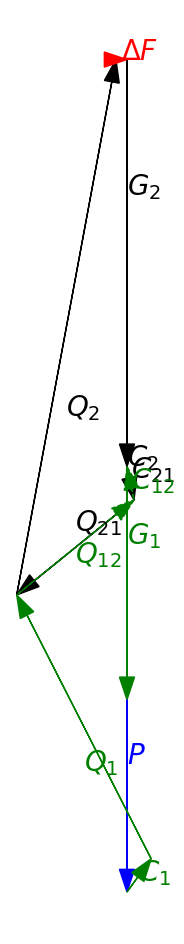

In [662]:
scale = np.linalg.norm(Q_21)
fig, ax = plt.subplots(figsize=(12,12))
vec_from_by(ax,delta=G_2,label=r'$G_2$',scale=scale)
vec_from_by(ax,fro=G_2,delta=C_2,label=r'$C_2$',scale=scale)
vec_from_by(ax,fro=G_2+C_2,delta=C_21,label=r'$C_{21}$',scale=scale)
vec_from_by(ax,fro=G_2+C_2+C_21,delta=Q_21,label=r'$Q_{21}$',scale=scale)
vec_from_by(ax,fro=G_2+C_2+C_21+Q_21,delta=Q_2,label=r'$Q_2$',scale=scale)
vec_from_by(ax,fro=G_2+C_2+C_21+Q_2+Q_21,delta=dF,label=r'$\Delta F$',scale=scale,col='red')
#
vec_from_by(ax,fro=G_2,delta=G_1,label=r'$G_{1}$',scale=scale,col='green')
vec_from_by(ax,fro=G_2+G_1,delta=P,label=r'$P$',scale=scale,col='blue')
vec_from_by(ax,fro=G_2+G_1+P,delta=C_1,label=r'$C_1$',scale=scale,col='green')
vec_from_by(ax,fro=G_2+G_1+P+C_1,delta=Q_1,label=r'$Q_1$',scale=scale,col='green')
vec_from_by(ax,fro=G_2+G_1+P+C_1+Q_1,delta=Q_12,label=r'$Q_{12}$',scale=scale,col='green',ls='--')
vec_from_by(ax,fro=G_2+G_1+P+C_1+Q_1+Q_12,delta=C_12,label=r'$C_{12}$',scale=scale,col='green',ls='--')
#
ax.set(adjustable='box', aspect='equal')
plt.axis('off');

## Variation des Bruchmechanismus und Berechnung von Sicherheitsfaktoren bzw. Ausnutzungsgraden

Im Rahmen des Teilsicherheitskonzeptes werden für die Einwirkungen bzw. die Scherparameter Bemessungswerte angesetzt. Diese werden dann mit Ausnutzungsgraden derart verringert, dass die mobilisierten Scherfestigkeitsparameter *ohne zusätzliche Traglast $\vec{P}_\text{T}$* (in unserem Fall: $\vec{P}_\text{T} = 0$) gerade zum Grenzgleichgewicht führen. Wie bei den bisherigen Verfahren auch, findet hierbei die Felleniusregel Anwendung.

$$
    \tan \varphi_\text{m} = \mu \tan \varphi_\text{d} \qquad c_\text{m} = \mu c_\text{d}
$$

Alternativ kann dessen Kehrwert, der Sicherheitsfaktor, verwendet werden:

$$
    \tan \varphi_\text{m} = \frac{\tan \varphi_\text{d}}{\eta} \qquad c_\text{m} = \frac{c_\text{d}}{\eta}
$$

In [663]:
additional = (H_top_slope,H_top_layer,35,27,10.5,5.6,0,19,18,45.5,1,6,False,12,54)
res = scp.optimize.root(fun=get_P_T_wl,x0=1.0,args=additional)
eta_v1 = res.x[0]
print("Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist %.2f, der Ausnutzungsgrad %.2f. Das liefert eine zusätzliche Traglast von %.2f kN/m" %(res.x[0],1/res.x[0],res.fun))

Der Sicherheitsfaktor für den gegebenen Bruchmechanismus ist 0.96, der Ausnutzungsgrad 1.04. Das liefert eine zusätzliche Traglast von 0.00 kN/m


## Finden des kritischsten Bruchmechanismus

Wir variieren nun die Winkel $\beta \in [-9°,45°]$ und $\vartheta \in [40°,80°]$ und suchen denjenigen Bruchmechanismus, der die geringste Sicherheit, also den größten Ausnutzungsgrad liefert.

In [664]:
bounds = scp.optimize.Bounds([-9,40],[45,80])

In [665]:
var = (H_top_slope,H_top_layer,35,27,10.5,5.6,0,19,18,45.5,1,6,False)
res = scp.optimize.minimize(fun=optimize_mechanism,x0=(10,50),args=var,bounds=bounds)
print("Der minimale Sicherheitsfaktor ist %.2f (entspricht einem Ausnutzungsgrad von %.2f) und tritt bei den Winkeln beta = %.2f° und theta = %.2f° auf." 
      %(res.fun,1/res.fun,res.x[0],res.x[1]))

Der minimale Sicherheitsfaktor ist 0.96 (entspricht einem Ausnutzungsgrad von 1.04) und tritt bei den Winkeln beta = 12.04° und theta = 53.63° auf.


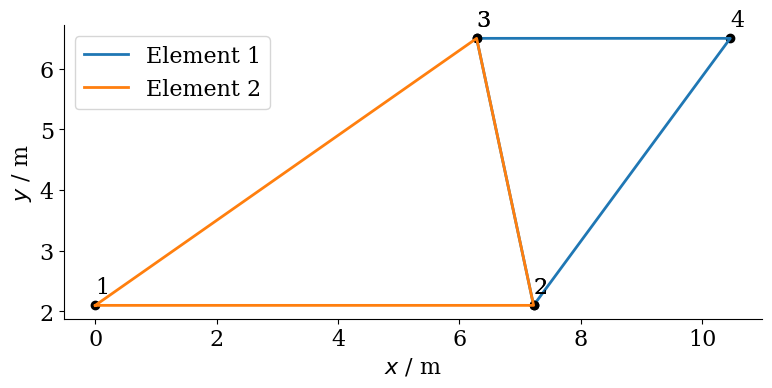

In [666]:
beta = np.deg2rad(res.x[0])
theta = np.deg2rad(res.x[1])
geometry = pd.DataFrame(np.array([[1],
                                  [0.0],
                                  [H_top_layer]]).T,
                   columns=['Pkt', 'x / m', 'y / m'])
geometry
dH = H_top_slope - H_top_layer
geometry = pd.concat([geometry,pd.DataFrame({'Pkt': 2, 'x / m': dH/np.tan(alpha) + dH*np.tan(beta), 'y / m': H_top_layer},index=[0])], ignore_index=True)
geometry = pd.concat([geometry,pd.DataFrame({'Pkt': 3, 'x / m': dH/np.tan(alpha), 'y / m': H_top_slope},index=[0])], ignore_index=True)
geometry = pd.concat([geometry,pd.DataFrame({'Pkt': 4, 'x / m': dH/np.tan(alpha) + dH*np.tan(beta) + dH/np.tan(theta), 'y / m': H_top_slope},index=[0])], ignore_index=True)
block1 = define_element(geometry,[3,2,4])
block2 = define_element(geometry,[1,2,3])
plot_blocks([block1,block2])

Wir lassen uns nun die Isoasphalien im Suchbereich $\beta \in [-45°,45°]$ und $\vartheta \in [50°,80°]$ darstellen (Berechnung dauert etwas; Achtung: läuft parallel auf 6 threads). Das oben gefundene Mininum wird im Suchbereich noch einmal graphisch als lokales Minimum bestätigt. Im Bereich negativer Winkel $\beta$ sind wir durch den vorgegebenen Mechanismus an folgende Zwangsbedingung gebunden: $90° + \beta < \vartheta$, da der Mechanismus sonst nicht sinnvoll definiert werden kann. Man beachte auch, dass in bestimmten Konfigurationen rechnerische Zugkräfte auftreten können und die betreffenden Mechanismen auszuschließen sind (diese traten bei $\beta < -20°$ vermehrt auf). Die Isoasphalien deuten die Möglichkeit an, dass bisherige lokale Minimum nicht dem globalen Minimum entspricht. Um jedoch im betreffenden Suchbereich sinnvolle Bruchmechanismen für eine weitere Optimierung zu definieren, ist über eine Erweiterung des Bruchmechanismus bspw. auf 3 Körper nachzudenken. Da aber mit dem oben identifizierten lokalen Minimum allerdings bereits eine Konfiguration gefunden wurde, die nicht standsicher ist, ist eine weitere Verfeinerung der Suche im vorliegenden Fall nicht von praktischem Interesse, sondern es sind zunächst konstruktive Maßnahmen zur Sicherung der Böschung zu prüfen.

**Achtung**: Analog ließe sich das Bild für Ausnutzungsgrade darstellen, wobei die Minimumsuche in eine äquivalente Maximumsuche überginge.

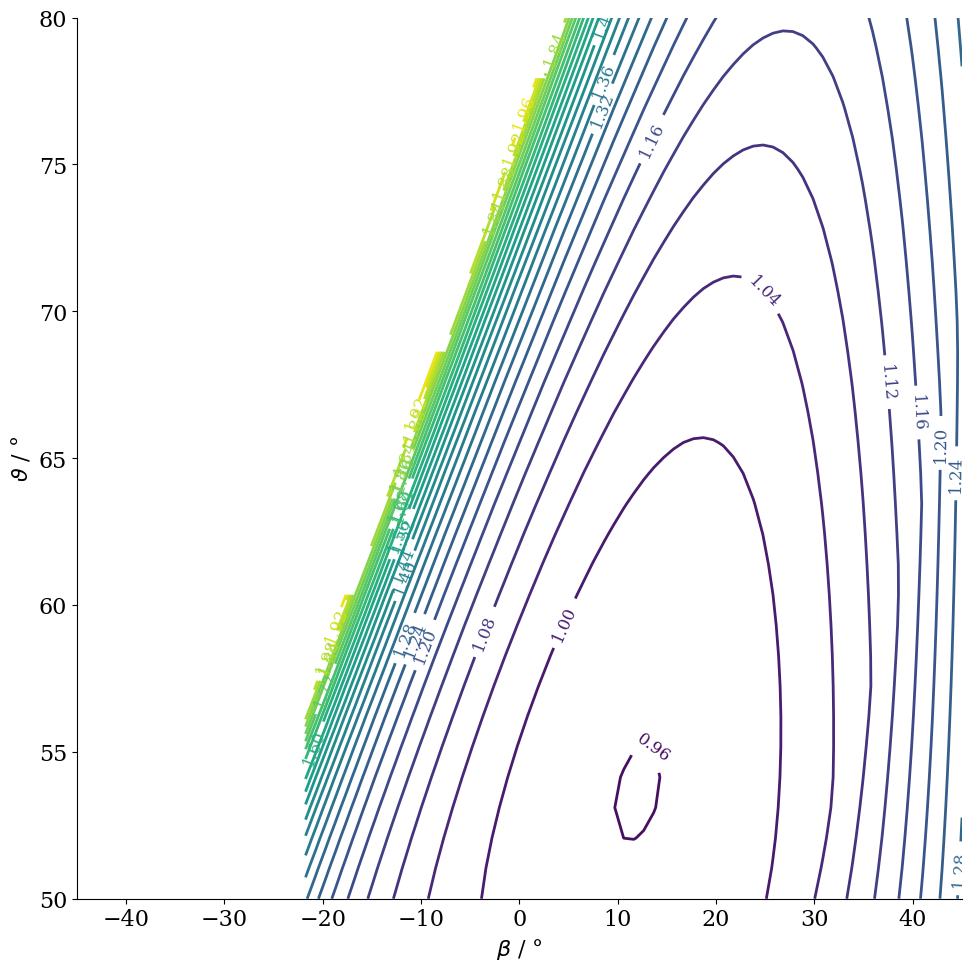

In [667]:
isoasphalien(True,n_workers=12)